In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, binary_closing, disk
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.exposure import equalize_adapthist
from skimage.segmentation import watershed
from scipy import ndimage as ndi

In [2]:
data = tifffile.imread('data/demoMovie.tif')
movie = (data - data.min(axis=(1, 2), keepdims=True)) / (np.ptp(data, axis=(1,2), keepdims=True))
movie.shape

(2000, 60, 80)

## Automated ROI Detection  
  
This module introduces a structured approach for identifying neurons automatically in calcium imaging datasets. Manual annotation is useful for small-scale analysis, but for large experiments, automated Region of Interest (ROI) detection is essential. The process will be divided into four stages — enhancing the image, intuition of candidate regions, refining masks, and evaluating results.

### **Preprocessing**  
  
Raw calcium imaging data often contains noise that can obscure the structure of neurons. Before beginning the detection process, it is important to enhance the image so that relevant features are easier to identify. In this section, you will generate projection images from the full movie and apply Gaussian filtering to reduce high-frequency noise. This will help reveal neuron shapes more clearly and improve the reliability of later detection steps.

**Exercise** Create mean projection

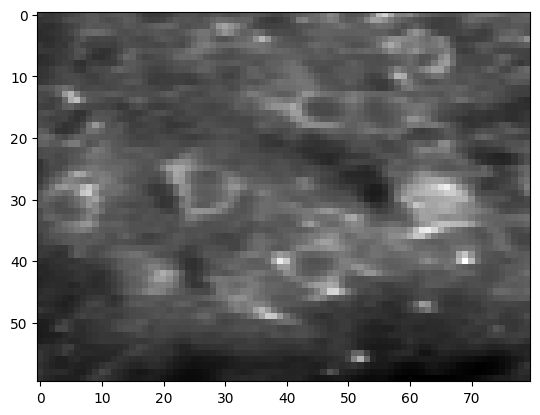

In [3]:
proj = np.mean(movie, axis=0)
plt.imshow(proj, cmap='gray')

**Exercise** Create max projection

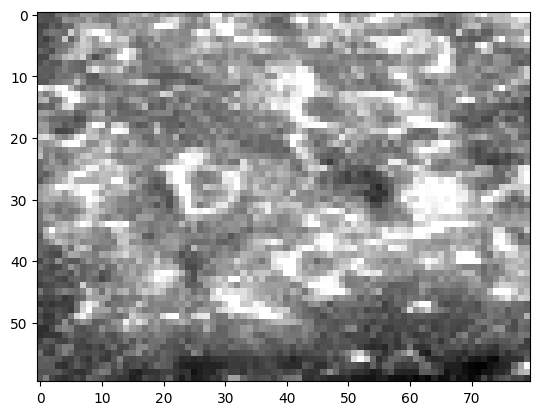

In [4]:
proj = np.max(movie, axis=0)
plt.imshow(proj, cmap='gray')

**Exercise** Create standard deviation projection

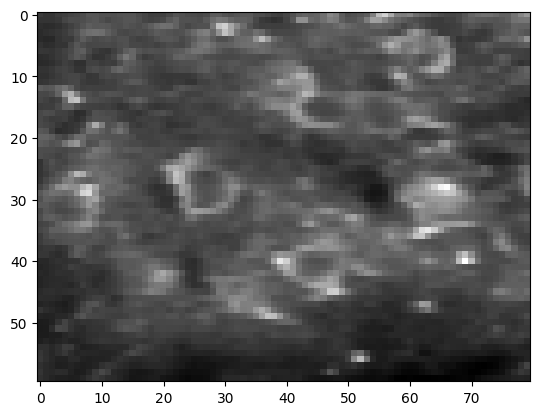

In [5]:
proj = np.std(movie, axis=0)
plt.imshow(proj, cmap='gray')

Gaussian filtering reduces high-frequency noise and enhances the appearance of cell-bodies

**Exercise** Apply gaussian filtering to mean projection image with sigma=1

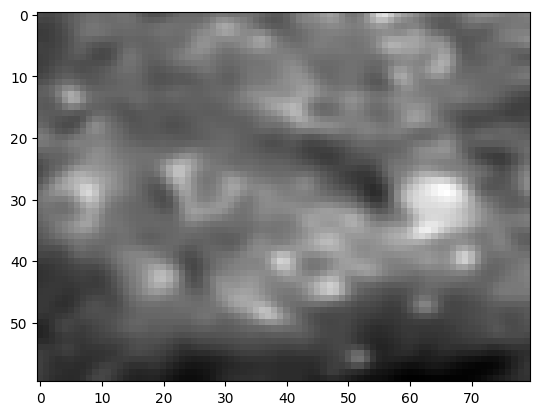

In [6]:
proj = np.mean(movie, axis=0)
proj_smooth = gaussian(proj, sigma=1)
plt.imshow(proj_smooth, cmap='gray')

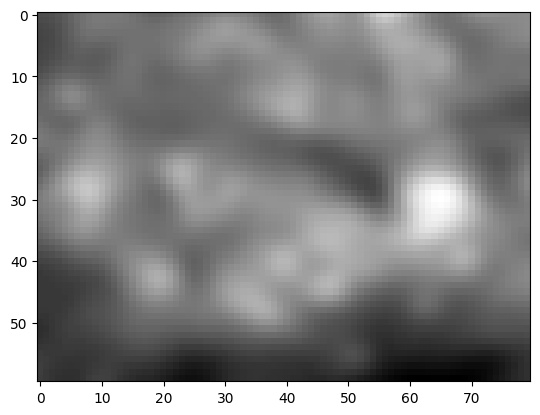

In [7]:
proj = np.mean(movie, axis=0)
proj_smooth = gaussian(proj, sigma=2)
plt.imshow(proj_smooth, cmap='gray')

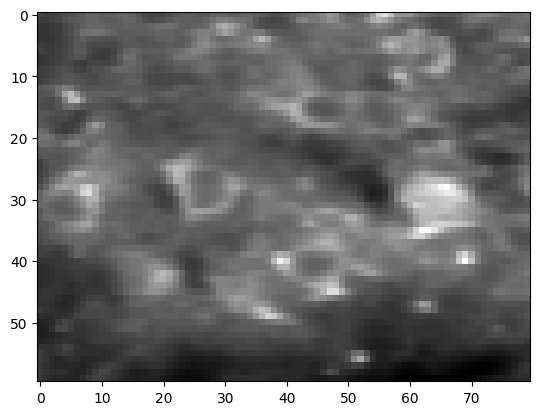

In [8]:
proj = np.mean(movie, axis=0)
proj_smooth = gaussian(proj, sigma=0.5)
plt.imshow(proj_smooth, cmap='gray')

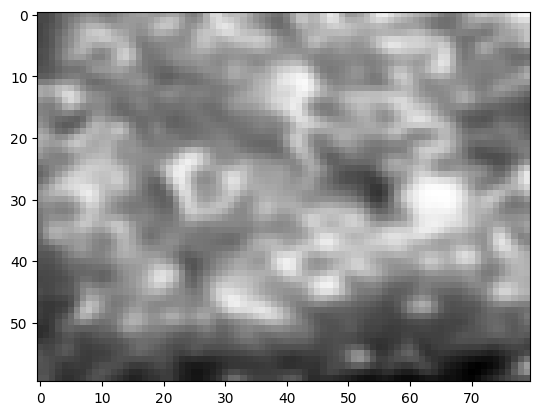

In [9]:
proj = np.max(movie, axis=0)
proj_smooth = gaussian(proj, sigma=1)
plt.imshow(proj_smooth, cmap='gray')

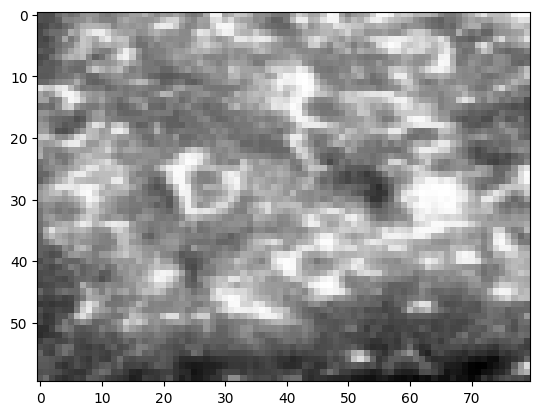

In [10]:
proj = np.max(movie, axis=0)
proj_smooth = gaussian(proj, sigma=0.5)
plt.imshow(proj_smooth, cmap='gray')

Compare raw and smooth image

**Exercise** Compare mean projection with its smoothed version (sigma=0.5)

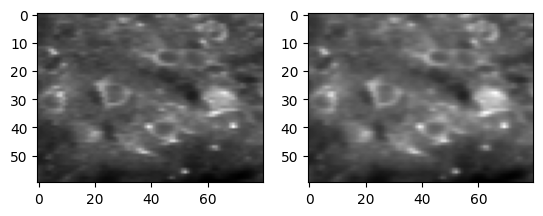

In [11]:
proj = np.mean(movie, axis=0)
proj_smooth = gaussian(proj, sigma=0.5)

plt.subplot(121)
plt.imshow(proj, cmap='gray')

plt.subplot(122)
plt.imshow(proj_smooth, cmap='gray')

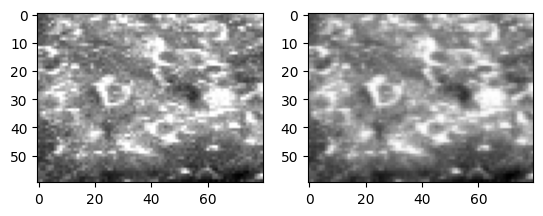

In [12]:
proj = np.max(movie, axis=0)
proj_smooth = gaussian(proj, sigma=0.5)

plt.subplot(121)
plt.imshow(proj, cmap='gray')

plt.subplot(122)
plt.imshow(proj_smooth, cmap='gray')

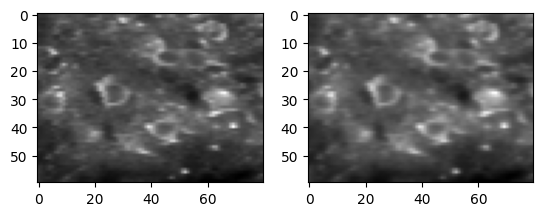

In [13]:
proj = np.std(movie, axis=0)
proj_smooth = gaussian(proj, sigma=0.5)

plt.subplot(121)
plt.imshow(proj, cmap='gray')

plt.subplot(122)
plt.imshow(proj_smooth, cmap='gray')


## Segmenting Neurons  

Candidate peaks provide approximate locations, but we need to define complete neuron shapes for signal extraction. In this section, you will refine ROI boundaries by applying image segmentation techniques. This includes thresholding the smoothed image, applying morphological operations to clean and close the binary mask.

**Example** What is the threshold if we want the components to be brighter than 1% of the pixels?

In [14]:
image = proj_smooth.copy()
thresh = np.percentile(image, 1)
thresh

0.052399711300790144

What is the threshold if we want the components to be brighter than 50% of the pixels?

In [15]:
image = proj_smooth.copy()
thresh = np.percentile(image, 50)
thresh

0.1032739279621287

What is the threshold if we want the components to be brighter than 90% of the pixels?

In [16]:
image = proj_smooth.copy()
thresh = np.percentile(image, 90)
thresh

0.13500765021892994

**Example** Apply binary mask for components brighter than 1% of the pixels.

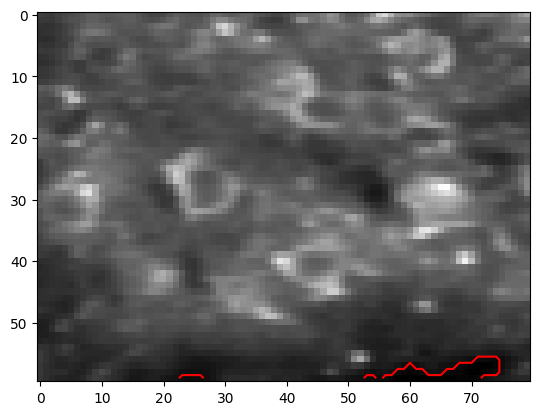

In [17]:
thresh = np.percentile(image, 1)
binary_mask = image > thresh
plt.imshow(image, cmap='gray')
plt.contour(binary_mask, colors='red')

Apply binary mask for components brighter than 50% of the pixels.

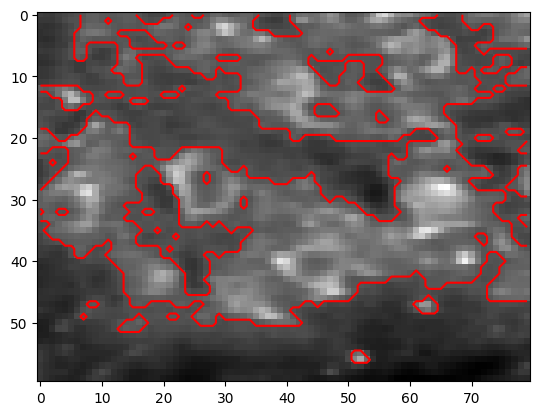

In [18]:
thresh = np.percentile(image, 50)
binary_mask = image > thresh
plt.imshow(image, cmap='gray')
plt.contour(binary_mask, colors='red')

Apply binary mask for components brighter than 90% of the pixels.

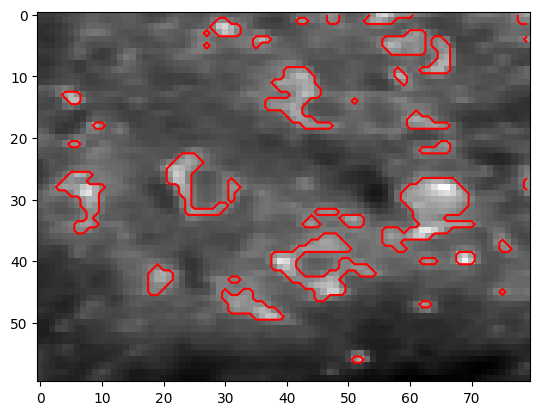

In [19]:
thresh = np.percentile(image, 90)
binary_mask = image > thresh
plt.imshow(image, cmap='gray')
plt.contour(binary_mask, colors='red')

Raw binary masks can be messy. They might include small noise specks, holes inside cells, or ragged edges. Morphological operations are a set of image transformations that improve the shape and quality of binary masks.

We will use two common operations here

- `remove_small_objects`: to get rid of specks and fragments that are too small to be cells.
- `binary_closing`: fills tiny holes and connects small gaps in neuron masks

`remove_small_objects` operation removes small, irrelevant objects from the binary mask that are smaller than specified number of pixels. 

**Example** Remove objects which are smaller than 2 pixels.

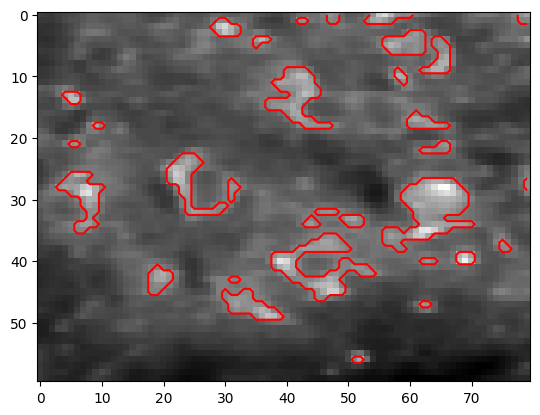

In [20]:
cleaned_mask = remove_small_objects(binary_mask, min_size=2)
plt.imshow(image, cmap='gray')
plt.contour(cleaned_mask, colors='red')

Remove objects which are smaller than 100 pixels.

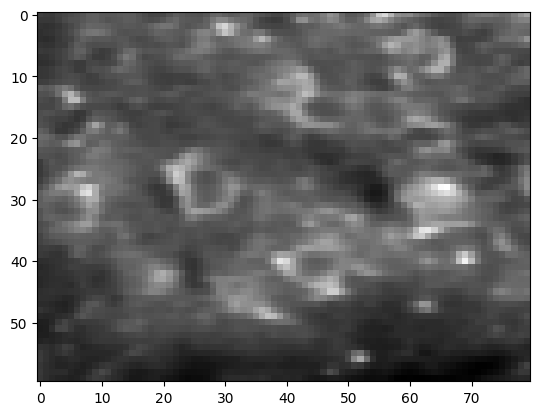

In [21]:
cleaned_mask = remove_small_objects(binary_mask, min_size=100)
plt.imshow(image, cmap='gray')
plt.contour(cleaned_mask, colors='red')

Remove objects which are smaller than 5 pixels.

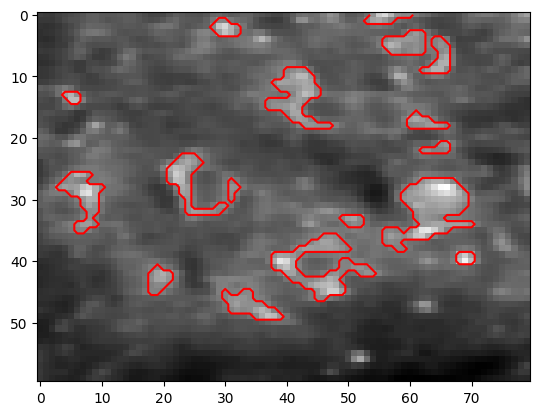

In [22]:
cleaned_mask = remove_small_objects(binary_mask, min_size=5)
plt.imshow(image, cmap='gray')
plt.contour(cleaned_mask, colors='red')

Closing the mask fills small gaps and holes within the segmented regions of the image, improving the shape of the objects of interest. This is done by expanding and then shrinking the regions in a smooth, circular pattern. `disk(2)` here creates a round structuring element with radius 2 pixels, used as a smoothing template.
 
**Example** Close the mask with a footprint of 3 pixels.

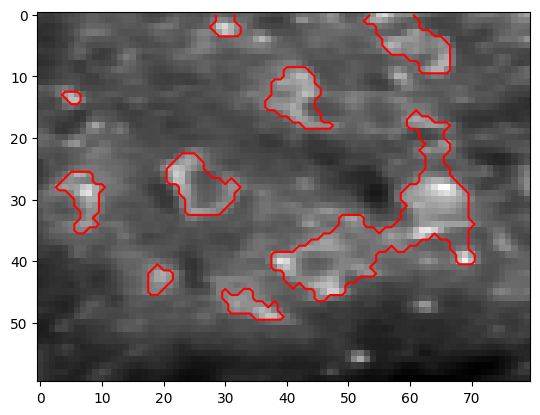

In [23]:
closed_mask = binary_closing(cleaned_mask, footprint=disk(3))
plt.imshow(image, cmap='gray')
plt.contour(closed_mask, colors='red')

Close the mask with a footprint of 10 pixels.

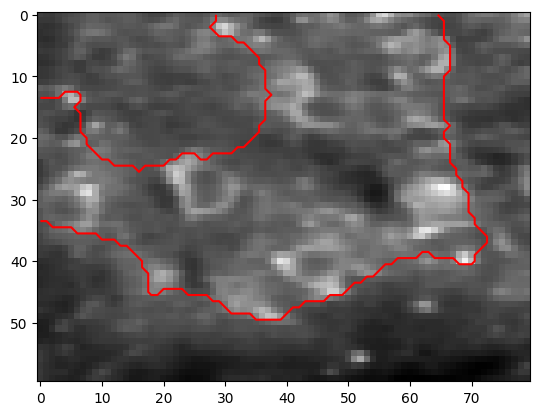

In [24]:
closed_mask = binary_closing(cleaned_mask, footprint=disk(10))
plt.imshow(image, cmap='gray')
plt.contour(closed_mask, colors='red')

Close the mask with a footprint of 0.6 pixels.

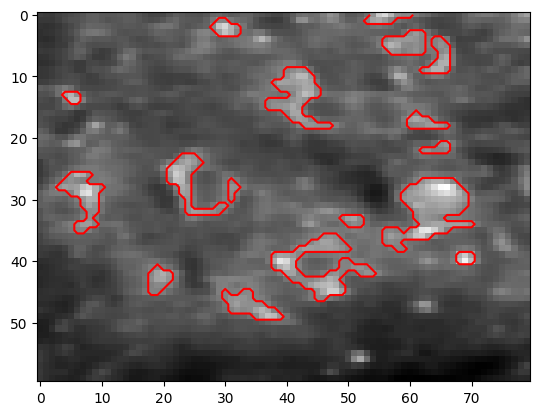

In [25]:
closed_mask = binary_closing(cleaned_mask, footprint=disk(0.6))
plt.imshow(image, cmap='gray')
plt.contour(closed_mask, colors='red')

## Identifying ROIs that need Splitting

Some of the ROIs may encompass more than one neuron. As imaging resolution and signal complexity increase, it becomes more common for automated methods to group nearby neurons into a single ROI. 

In [26]:
labeled_rois = label(closed_mask)
np.unique(labeled_rois)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

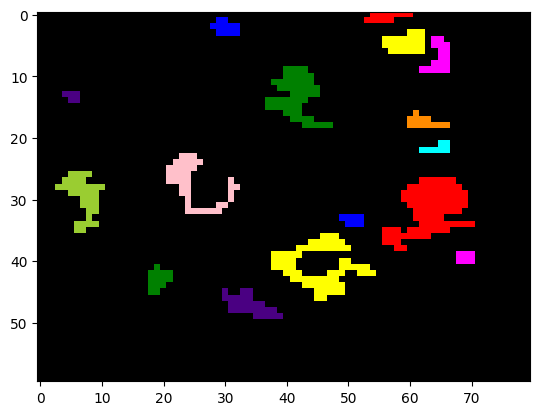

In [27]:
overlay = label2rgb(labeled_rois, bg_label=0)
plt.imshow(overlay, cmap="gray")

Plotting individual rois

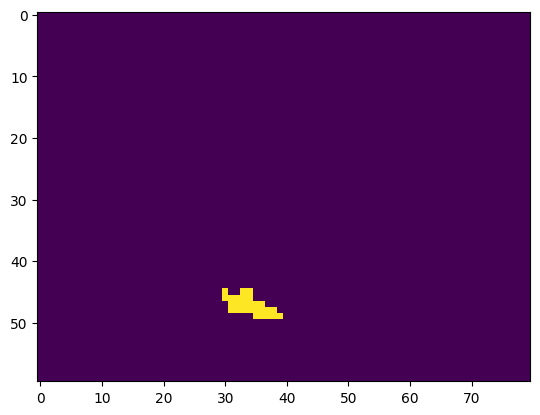

In [28]:
roi = labeled_rois == 16
plt.imshow(roi)

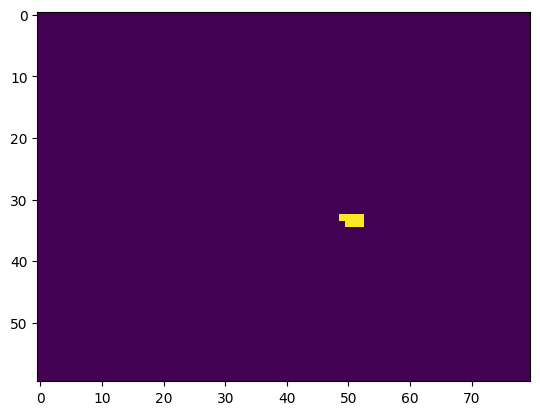

In [29]:
roi = labeled_rois == 12
plt.imshow(roi)

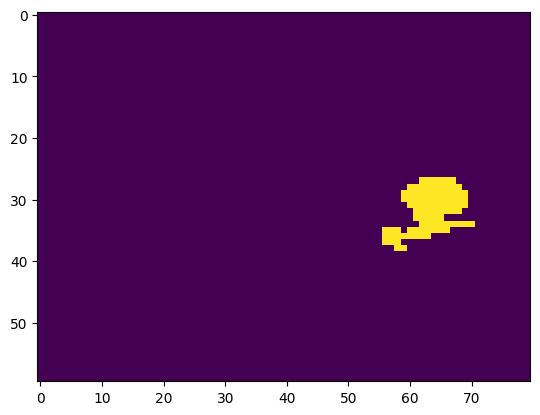

In [30]:
roi = labeled_rois == 11
plt.imshow(roi)

How many local intensity peaks are in ROI 16?

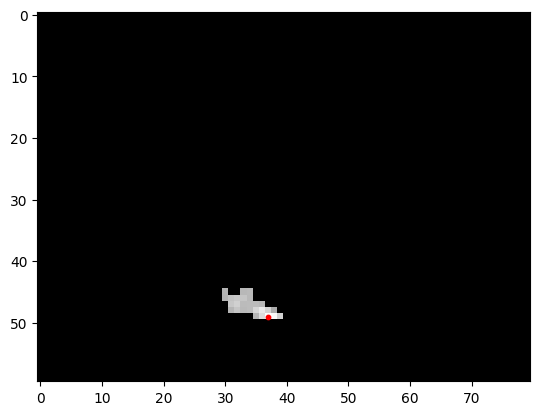

In [31]:
roi = labeled_rois == 16
roi_crop = proj * roi
coords = peak_local_max(roi_crop, min_distance=5)
plt.imshow(roi_crop, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

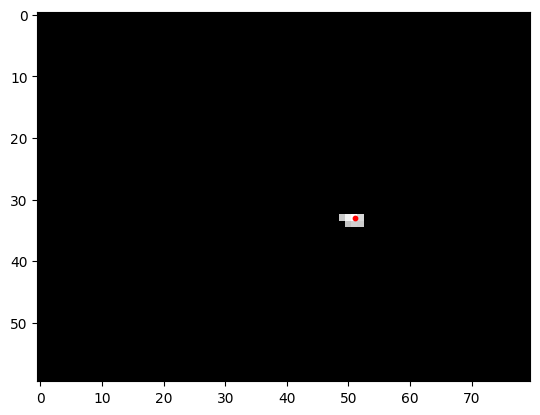

In [32]:
roi = labeled_rois == 12
roi_crop = proj * roi
coords = peak_local_max(roi_crop, min_distance=5)
plt.imshow(roi_crop, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

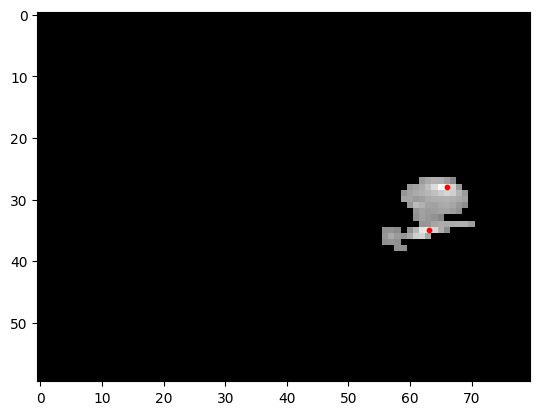

In [33]:
roi = labeled_rois == 11
roi_crop = proj * roi
coords = peak_local_max(roi_crop, min_distance=5)
plt.imshow(roi_crop, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

We first enhance the image through adaptive histogram equalization which will make it easier to see small variations. The parameter `clip_limit` controls how aggressive the enhancement is.

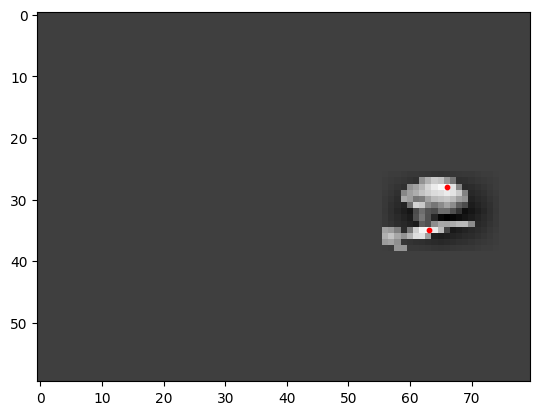

In [34]:
roi_crop_norm = roi_crop / roi_crop.max()
enhanced = equalize_adapthist(roi_crop_norm, clip_limit=0.4)
plt.imshow(enhanced, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

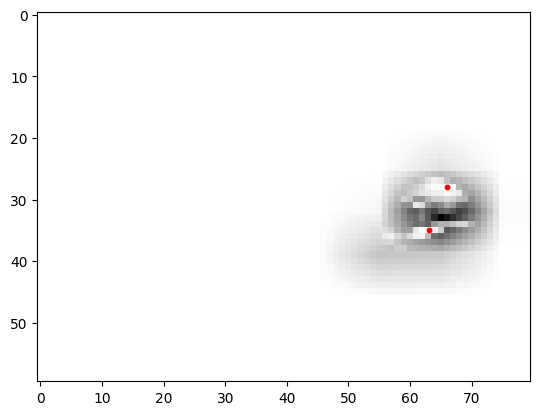

In [35]:
roi_crop_norm = roi_crop / roi_crop.max()
enhanced = equalize_adapthist(roi_crop_norm, clip_limit=1.0)
plt.imshow(enhanced, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

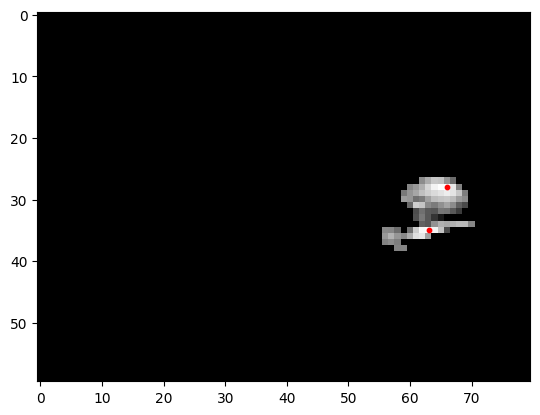

In [36]:
roi_crop_norm = roi_crop / roi_crop.max()
enhanced = equalize_adapthist(roi_crop_norm, clip_limit=0.1)
plt.imshow(enhanced, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

## Watershed Algorithm For Splitting ROIs

The watershed algorithm is a technique that treats the image like a topographic surface, where pixel intensity represents elevation. It "floods" the image from marked points (called markers), and boundaries (edges) are determined by the "watershed lines" where the flooding from different markers meets.

The watershed algorithm uses markers to start the flooding process and a distance map to guide the flow. A distance map is an image where each pixel represents the distance from that pixel to the nearest background pixel

Markers are just the co-ordinates of local intensity peaks which should be converted to labeled markers.

ROI 11

In [37]:
roi = labeled_rois == 11
roi_crop = proj * roi
roi_crop_norm = roi_crop / roi_crop.max()
enhanced = equalize_adapthist(roi_crop_norm, clip_limit=0.1)
coords = peak_local_max(enhanced, min_distance=5)
markers = np.zeros_like(enhanced, dtype=np.int32)
for i, (y, x) in enumerate(coords):
    markers[y, x] = i + 1

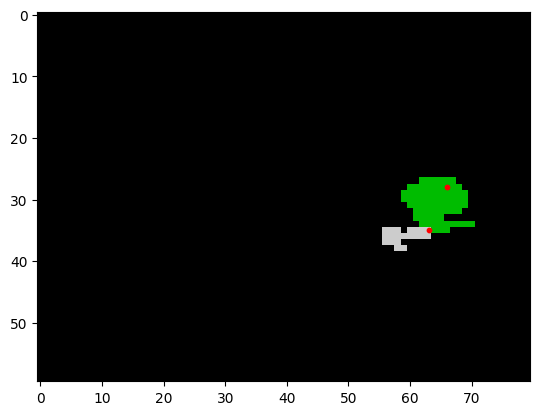

In [38]:
distance = ndi.distance_transform_edt(enhanced)
labels = watershed(-distance, markers, mask=roi)
plt.imshow(labels, cmap="nipy_spectral")
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

ROI 13

In [39]:
roi = labeled_rois == 13
roi_crop = proj * roi
roi_crop_norm = roi_crop / roi_crop.max()
enhanced = equalize_adapthist(roi_crop_norm, clip_limit=0.1)
coords = peak_local_max(enhanced, min_distance=5)
markers = np.zeros_like(enhanced, dtype=np.int32)
for i, (y, x) in enumerate(coords):
    markers[y, x] = i + 1

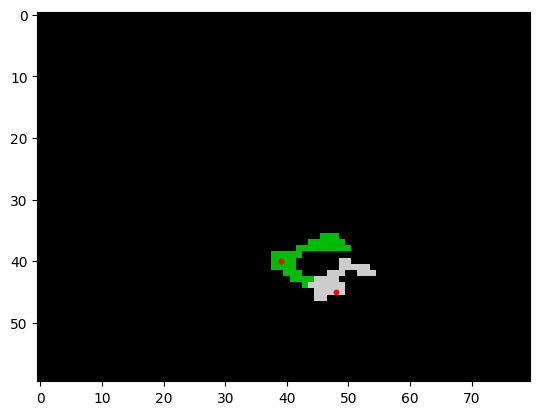

In [40]:
distance = ndi.distance_transform_edt(enhanced)
labels = watershed(-distance, markers, mask=roi)
plt.imshow(labels, cmap="nipy_spectral")
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

ROI 9

In [41]:
roi = labeled_rois == 9
roi_crop = proj * roi
roi_crop_norm = roi_crop / roi_crop.max()
enhanced = equalize_adapthist(roi_crop_norm, clip_limit=0.1)
coords = peak_local_max(enhanced, min_distance=5)
markers = np.zeros_like(enhanced, dtype=np.int32)
for i, (y, x) in enumerate(coords):
    markers[y, x] = i + 1

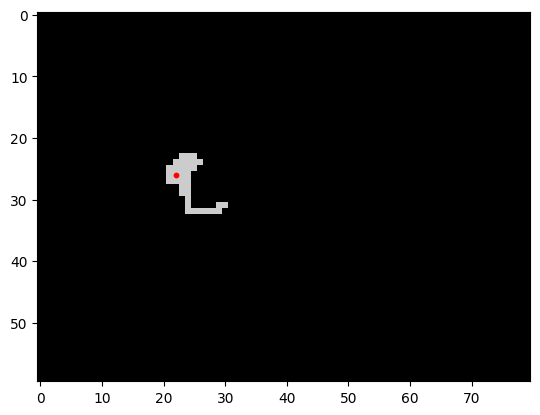

In [42]:
distance = ndi.distance_transform_edt(enhanced)
labels = watershed(-distance, markers, mask=roi)
plt.imshow(labels, cmap="nipy_spectral")
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')